In [6]:
import pandas as pd

# TODO: update for state
STATE = 'ma'
YEARS = [str(yr) for yr in range(2011, 2020)]

In [19]:
"""
File naming convension for ACS 5-year downloads:
state_year_[race|income].csv

"""

def get_filepath(state):
    return '../data/{state}/'.format(state=state)

def get_fname(state, year, dataset_type):
    return '{state}_{year}_{dataset_type}.csv'.format(
        state=state, year=year, dataset_type=dataset_type)

def get_filename(state, year, dataset_type):
    return get_filepath(state) + get_fname(state, year, dataset_type)


# geoid is the column we join data on
geoid_column_name = 'geoid'

geoid_column_map = {
    'GEO.id2': geoid_column_name,
    'GEO_ID': geoid_column_name
}

# for some reason particular file(s) have different column names- WHY?!
filename_income_column_map = {
    'ma_2017_income.csv': {
        'HC03_EST_VC02': 'median income',
        'HC03_MOE_VC02': 'median income margin of error',
        'HD01_VD01': 'median income',
        'HD02_VD01': 'median income margin of error'
    }
}
# Here is the default
income_column_map = {
    'HC02_EST_VC02': 'median income',
    'HC02_MOE_VC02': 'median income margin of error',
    'HD01_VD01': 'median income',
    'HD02_VD01': 'median income margin of error'
}

new_income_map = {
    'S1903_C03_001E': 'median income',
    'S1903_C03_001M': 'median income margin of error'
}

new_income_map_early = {
    'S1903_C02_001E': 'median income',
    'S1903_C02_001M': 'median income margin of error'
}

race_column_map = {
    'HD01_VD01': 'race: total households',
    'HD02_VD01': 'race: total households margin of error',
    'HD01_VD02': 'race: White',
    'HD01_VD03': 'race: Black',
    'HD01_VD05': 'race: Asian',
    'HD01_VD08': 'race: 2 or more races',
    # The following are combined into one value
    # 'HD01_VD04': 'race: American Indian and Alaska',
    # 'HD01_VD06': 'race: Native Hawaiian and Other',
    'HD01_VD07': 'race: Other',
}

new_race_column_map = {
    'B02001_001E': 'race: total households',
    'B02001_001M': 'race: total households margin of error',
    'B02001_002E': 'race: White',
    'B02001_003E': 'race: Black',
    'B02001_005E': 'race: Asian',
    'B02001_008E': 'race: 2 or more races',
    'B02001_007E': 'race: Other'
}

def race_combine_other(row):
    
    """Combines the values for the other races with american indian, hawaiian, etc"""
    try:
        return int(row['HD01_VD04']) + int(row['HD01_VD06']) + int(row['HD01_VD07'])
    except:
        return int(row['B02001_004E']) + int(row['B02001_006E']) + int(row['B02001_007E'])

def col_name_for_year(year, col_name):
    return str(year) + ' ' + col_name

def remove_labels(df):
    # drop the first row (the first row is a display label)
    df.drop([0], inplace=True)

def preprocess_df(df, year, column_map):
    # prune data
    # data from 2018-onwards only has GEO_ID not GEO.id2
    if int(year) > 2017:
        for num in range(1, df.shape[0]+1):
            df.at[num, 'GEO_ID'] = df.at[num, 'GEO_ID'][-11:]
    # for num in range(1, df.shape[0]+1):
    #     df.at[num, 'GEO_ID'] = df.at[num, 'GEO_ID'][-11:]  
    # rename columns
    column_name_map = {key: col_name_for_year(year, value) for key, value in column_map.items()}
    
    column_name_map.update(geoid_column_map)
    cols_to_drop = [col for col in df.columns if not col in column_name_map.keys()]

    df.drop(cols_to_drop,  axis=1,  inplace=True)
    df.rename(columns=column_name_map, inplace=True)
    df.set_index(geoid_column_name, inplace=True)
    return df


def get_race_df(state, year):
    filename = get_filename(STATE, year, 'race')
    df = pd.read_csv(filename)
    remove_labels(df)
    df['column'] = df.apply(race_combine_other, axis=1)
    if int(year) > 2017:
        map = new_race_column_map
    else:
        map = race_column_map
    return preprocess_df(df, year, map)


def get_income_df(state, year):
    # so annoying that the columns change with files!
    if int(year) > 2017:
        map = new_income_map
    else:
        map = income_column_map
    fname = get_fname(state, year, 'income')
    print('filename', fname)
    if fname in filename_income_column_map:
        map = filename_income_column_map[fname]
    df = pd.read_csv(get_filename(STATE, year, 'income'))
    print('income:df', df)
    remove_labels(df)
    return preprocess_df(df, year, map)


In [20]:
# We merge data into the income df

def add_df(df1, df2):
    # comebine the df's on geoid
    return pd.concat([df1, df2], axis=1, join='inner')

state_df = None
for year in YEARS:
    print('handling files for year ', year)
    income_df = get_income_df(STATE, year)
    if state_df is None:
        state_df = income_df
    else:
        state_df = add_df(state_df, income_df)
    # print(state_df)
    race_df = get_race_df(STATE, year)
    state_df = add_df(state_df, race_df)
# state_df = state_df.loc[state_df[geoid_column_name] == '48201410802']
state_df.head()



handling files for year  2011
filename ma_2011_income.csv
income:df                     GEO.id      GEO.id2  \
0                       Id          Id2   
1     1400000US25001010100  25001010100   
2     1400000US25001010206  25001010206   
3     1400000US25001010208  25001010208   
4     1400000US25001010304  25001010304   
...                    ...          ...   
1474  1400000US25027760100  25027760100   
1475  1400000US25027761100  25027761100   
1476  1400000US25027761200  25027761200   
1477  1400000US25027761300  25027761300   
1478  1400000US25027761400  25027761400   

                                      GEO.display-label  \
0                                             Geography   
1     Census Tract 101, Barnstable County, Massachus...   
2     Census Tract 102.06, Barnstable County, Massac...   
3     Census Tract 102.08, Barnstable County, Massac...   
4     Census Tract 103.04, Barnstable County, Massac...   
...                                                 ...   
14

,2011 median income,2011 median income margin of error,2011 race: total households,2011 race: total households margin of error,2011 race: White,2011 race: Black,2011 race: Asian,2011 race: Other,2011 race: 2 or more races,2012 median income,...,2018 race: 2 or more races,2019 median income,2019 median income margin of error,2019 race: total households,2019 race: total households margin of error,2019 race: White,2019 race: Black,2019 race: Asian,2019 race: Other,2019 race: 2 or more races
geoid,,,,,,,,,,,,,,,,,,,,,
25001010100,46547,3913,2994,13,2787,109,0,0,98,46031,...,158,59063,8028,2973,26,2718,57,35,44,119
25001010206,59234,11997,2858,256,2774,2,0,16,66,54959,...,119,74639,5128,3617,275,3270,70,120,35,122
25001010208,71964,38247,1903,260,1855,0,17,0,0,81964,...,5,68367,5644,1122,275,1083,38,0,0,1
25001010304,69659,23145,2395,269,2335,15,22,0,7,70000,...,23,85263,15020,2394,212,2207,27,134,0,26
25001010306,50357,16558,2616,270,2563,9,44,0,0,51047,...,50,70071,13542,2507,215,2321,56,17,48,42


In [21]:
# Save the giant dataframe to CSV
output_csvfilename = get_filepath(STATE) + 'race_and_income_data.csv'
state_df.to_csv(output_csvfilename)
print('saved data to ',  output_csvfilename)

saved data to  ../data/ma/race_and_income_data.csv


In [22]:
import geopandas as gpd

In [23]:
"""Creates shapefile from NYC open data download.
This shapefile does not have geoids, so must add them based on its other data.

"""

NY_STATE_CODE = '36'

nyc_shapefile_attributes = {
    geoid_column_name: geoid_column_name,
    'ntaname': 'Name', # name of neighborhood in this dataset
    # Tracts are duplicated across boros.
    # The unique key is 'boro_ct201' which is the concatenation of boro id and ct
    # 'ct2010': 'tract',
    'shape_area': 'shape_area',
    'shape_leng': 'shape_leng',
    'geometry': 'geometry'
}
ma_shapefile_attributes = {
    'GEOID10': geoid_column_name,
    'NAMELSAD10': 'Name', # 'Census Tract ###'  in this dataset
    'SHAPE_AREA': 'shape_area',
    'SHAPE_LEN': 'shape_leng',
    'geometry': 'geometry'
}

hou_shapefile_attributes = {
    'GEOID': geoid_column_name,
    'NAMELSAD': 'Name',
    'AREA': 'shape_area',
    'geometry': 'geometry'
}

# Mapping of boro names to county code for geoid
# Taken from wikipedia info: https://en.wikipedia.org/wiki/List_of_counties_in_New_York
nyc_boro_to_county_code = {
    'Bronx':'005',
    'Queens':'081',
    'Brooklyn':'047',
    'Manhattan':'061',
    'Staten Island':'085'
}


def get_nyc_shapefile():
    shapefile_filename = get_filepath('ny') + 'city_census_tracts_shapefile/geo_export_6f3df1e4-1be2-4395-ba6c-3e15b0a10221.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_df[geoid_column_name] = shapefile_df.apply(get_nyc_geoid, axis=1)
    return shapefile_df


def get_nyc_county_code(row):
    boro_name = row['boro_name']
    return nyc_boro_to_county_code[boro_name]


def get_nyc_geoid(row):
    state_code = NY_STATE_CODE
    county_code = get_nyc_county_code(row)
    tract_code = row['ct2010']
    return str(state_code) + str(county_code) + str(tract_code)

shapefile_df = None
if STATE == 'ny':
    shapefile_df = get_nyc_shapefile()
    shapefile_attributes = nyc_shapefile_attributes
elif STATE == 'ma':
    shapefile_filename = get_filepath(STATE) + 'shapefile/boston-brookline-cambridge-somerville-everett.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_attributes = ma_shapefile_attributes
elif STATE == 'tx':
    shapefile_filename = get_filepath(STATE) + 'shapefiles/tl_2019_48_tract.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_df = shapefile_df.loc[shapefile_df["COUNTYFP"] == '201']
    shapefile_df["AREA"] = shapefile_df["ALAND"].astype(int) + shapefile_df["AWATER"].astype(int)
    shapefile_attributes = hou_shapefile_attributes
elif STATE == 'dc':
    shapefile_filename = get_filepath(STATE) + 'shapefile/DC/tl_2019_11_tract.shp'
    dc_shapefile_df = gpd.read_file(shapefile_filename)

    shapefile_filename = get_filepath(STATE) + 'shapefile/MD/tl_2019_24_tract.shp'
    md_shapefile_df = gpd.read_file(shapefile_filename)
    md_shapefile_df1 = md_shapefile_df.loc[md_shapefile_df["COUNTYFP"] == '031']
    md_shapefile_df2 = md_shapefile_df.loc[md_shapefile_df["COUNTYFP"] == '033']
    md_shapefile_df = pd.concat([md_shapefile_df1, md_shapefile_df2], axis = 0)

    shapefile_filename = get_filepath(STATE) + 'shapefile/VA/tl_2019_51_tract.shp'
    va_shapefile_df = gpd.read_file(shapefile_filename)
    va_shapefile_df1 = va_shapefile_df.loc[va_shapefile_df["COUNTYFP"] == '013']
    va_shapefile_df2 = va_shapefile_df.loc[va_shapefile_df["COUNTYFP"] == '510']
    va_shapefile_df = pd.concat([va_shapefile_df1, va_shapefile_df2], axis = 0)

    shapefile_df = pd.concat([dc_shapefile_df, va_shapefile_df, md_shapefile_df], axis = 0)
    shapefile_df["AREA"] = shapefile_df["ALAND"].astype(int) + shapefile_df["AWATER"].astype(int)
    shapefile_attributes = hou_shapefile_attributes

elif STATE == 'il':
    shapefile_filename = get_filepath(STATE) + 'shapefile/tl_2019_17_tract.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_df = shapefile_df.loc[shapefile_df["COUNTYFP"] == '031']
    shapefile_df["AREA"] = shapefile_df["ALAND"].astype(int) + shapefile_df["AWATER"].astype(int)
    shapefile_attributes = hou_shapefile_attributes

elif STATE == 'socal':
    shapefile_filename = get_filepath(STATE) + 'shapefiles/tl_2019_06_tract.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_df = shapefile_df.loc[shapefile_df["COUNTYFP"] == '037']
    shapefile_df["AREA"] = shapefile_df["ALAND"].astype(int) + shapefile_df["AWATER"].astype(int)
    shapefile_attributes = hou_shapefile_attributes
elif STATE == 'pa':
    shapefile_filename = get_filepath(STATE) + 'shapefiles/tl_2019_42_tract.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_df = shapefile_df.loc[shapefile_df["COUNTYFP"] == '101']
    shapefile_df["AREA"] = shapefile_df["ALAND"].astype(int) + shapefile_df["AWATER"].astype(int)
    shapefile_attributes = hou_shapefile_attributes

shapefile_df


,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,ALAND10,AWATER10,INTPTLAT10,...,AREA_ACRES,POP100_RE,HU100_RE,LOGPL94171,LOGSF1,LOGACS0610,LOGSF1C,SHAPE_AREA,SHAPE_LEN,geometry
0,25,021,401200,25021401200,4012,Census Tract 4012,G5020,6692464.0,32335.0,+42.3146076,...,1661.6151,7031,2645,0141546,123438,0003622,0123438,6.724345e+06,11423.687064,"POLYGON ((230135.432 895483.029, 230125.954 89..."
1,25,021,401100,25021401100,4011,Census Tract 4011,G5020,4116857.0,109099.0,+42.3238531,...,1044.1827,4441,1629,0141542,123434,0003621,0123434,4.225675e+06,11885.022027,"POLYGON ((230635.043 897756.710, 230632.614 89..."
2,25,021,401000,25021401000,4010,Census Tract 4010,G5020,640097.0,580.0,+42.3274299,...,158.3029,3149,1342,0141538,123430,0003620,0123430,6.406316e+05,3428.999786,"POLYGON ((231725.302 897626.698, 231722.282 89..."
3,25,021,400900,25021400900,4009,Census Tract 4009,G5020,383245.0,2025.0,+42.3332089,...,95.1955,3865,2017,0141534,123426,0003619,0123426,3.852440e+05,2872.982317,"POLYGON ((232018.183 898306.152, 232011.209 89..."
4,25,021,400800,25021400800,4008,Census Tract 4008,G5020,567433.0,5033.0,+42.3387738,...,141.4504,5630,2636,0141530,123422,0003618,0123422,5.724317e+05,3649.975331,"POLYGON ((231517.074 899012.450, 231587.350 89..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,25,017,342600,25017342600,3426,Census Tract 3426,G5020,454290.0,0.0,+42.4049931,...,112.2504,4365,1683,0102499,106928,0003440,0106928,4.542630e+05,2615.916206,"POLYGON ((238064.238 906300.299, 238054.782 90..."
254,25,017,342500,25017342500,3425,Census Tract 3425,G5020,794642.0,0.0,+42.4075792,...,196.3478,6797,2781,0102495,106924,0003439,0106924,7.945945e+05,4272.731339,"POLYGON ((237396.054 906978.293, 237396.813 90..."
255,25,017,342400,25017342400,3424,Census Tract 3424,G5020,3935068.0,628602.0,+42.3989732,...,975.0218,6055,2553,0102489,106918,0003438,0106918,3.945789e+06,14248.200003,"MULTIPOLYGON (((235423.652 907050.374, 235470...."
256,25,017,342300,25017342300,3423,Census Tract 3423,G5020,794509.0,0.0,+42.4121988,...,196.3152,6826,2754,0102484,106913,0003437,0106913,7.944624e+05,3703.957313,"POLYGON ((236743.956 906918.976, 236703.024 90..."


In [24]:
# Map column names and remove columns
shapefile_cols_to_drop = [col for col in shapefile_df.columns if not col in shapefile_attributes.keys()]
shapefile_df.drop(shapefile_cols_to_drop,  axis=1,  inplace=True)
shapefile_df.rename(columns=shapefile_attributes, inplace=True)
shapefile_df.head()
shapefile_df.set_index(geoid_column_name, inplace=True)
shapefile_df.head() 



,Name,shape_area,shape_leng,geometry
geoid,,,,
25021401200,Census Tract 4012,6.724345e+06,11423.687064,"POLYGON ((230135.432 895483.029, 230125.954 89..."
25021401100,Census Tract 4011,4.225675e+06,11885.022027,"POLYGON ((230635.043 897756.710, 230632.614 89..."
25021401000,Census Tract 4010,6.406316e+05,3428.999786,"POLYGON ((231725.302 897626.698, 231722.282 89..."
25021400900,Census Tract 4009,3.852440e+05,2872.982317,"POLYGON ((232018.183 898306.152, 232011.209 89..."
25021400800,Census Tract 4008,5.724317e+05,3649.975331,"POLYGON ((231517.074 899012.450, 231587.350 89..."


c:\Users\Walter\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

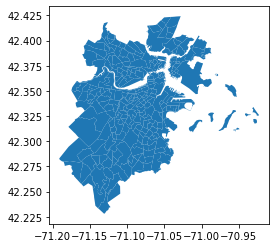

In [25]:
# Want projection CRS84 which is equivalent to EPSG:4326
shapefile_df = shapefile_df.to_crs({'init': 'epsg:4326'})

%matplotlib inline
shapefile_df.plot()

In [26]:
merged_shapes = shapefile_df.merge(state_df, on=geoid_column_name)
print('shape', merged_shapes.shape)
merged_shapes.head()

shape (258, 85)


,Name,shape_area,shape_leng,geometry,2011 median income,2011 median income margin of error,2011 race: total households,2011 race: total households margin of error,2011 race: White,2011 race: Black,...,2018 race: 2 or more races,2019 median income,2019 median income margin of error,2019 race: total households,2019 race: total households margin of error,2019 race: White,2019 race: Black,2019 race: Asian,2019 race: Other,2019 race: 2 or more races
geoid,,,,,,,,,,,,,,,,,,,,,
25021401200,Census Tract 4012,6.724345e+06,11423.687064,"POLYGON ((-71.13448 42.30925, -71.13460 42.309...",131875,15448,6831,552,4819,192,...,329,174667,58266,7095,427,4668,375,1341,217,494
25021401100,Census Tract 4011,4.225675e+06,11885.022027,"POLYGON ((-71.12830 42.32970, -71.12833 42.329...",161333,42691,4474,354,3751,34,...,317,189643,39027,3967,279,2910,139,627,35,256
25021401000,Census Tract 4010,6.406316e+05,3428.999786,"POLYGON ((-71.11508 42.32849, -71.11512 42.328...",84318,30474,3028,263,2305,87,...,295,123295,13162,3307,239,2187,191,462,81,377
25021400900,Census Tract 4009,3.852440e+05,2872.982317,"POLYGON ((-71.11149 42.33459, -71.11157 42.334...",71417,20311,3871,386,2646,194,...,36,85833,17295,4089,260,2881,258,786,87,59
25021400800,Census Tract 4008,5.724317e+05,3649.975331,"POLYGON ((-71.11753 42.34097, -71.11668 42.340...",65192,23920,5396,459,4007,91,...,89,87139,16044,5349,443,3922,76,1175,24,152


In [27]:
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

In [28]:
to_filename = get_filepath(STATE) + STATE  + '_census_tracts.geojson'
print('saving to ',to_filename)
merged_shapes["geometry"] = [MultiPolygon([feature]) if type(feature) == Polygon \
    else feature for feature in merged_shapes["geometry"]]
merged_shapes.to_file(to_filename, driver='GeoJSON')
print('saved')
sort = False

saving to  ../data/ma/ma_census_tracts.geojson
saved
